In [1]:
from utils import *
import re

Curve fitting & sampling

In [79]:
# import data
snakemake_contigs = SeqIO.to_dict(SeqIO.parse('../../data/contigs/contigs_non_cellular_filtered.fasta', "fasta"))

# extract contig names and lengths
df = pd.DataFrame({
    'contig_name': list(snakemake_contigs.keys()),
    'contig_length': [len(str(record.seq)) for record in snakemake_contigs.values()]
})

# import fitted_curve_lens_freq.json
xy_dict = mpu.io.read('../results/training/sampling/fitted_curve_lens_freq.json')
xy_dict_sampled = mpu.io.read('results/training/sampling/fitted_curve_lens_freq_sampled.json')

# Convert dictionary keys and values to numpy arrays
xfine = np.array([float(key) for key in xy_dict.keys()])
y_fitted = np.array(list(xy_dict.values()))
sample_y_fitted = np.array(list(xy_dict_sampled.values()))

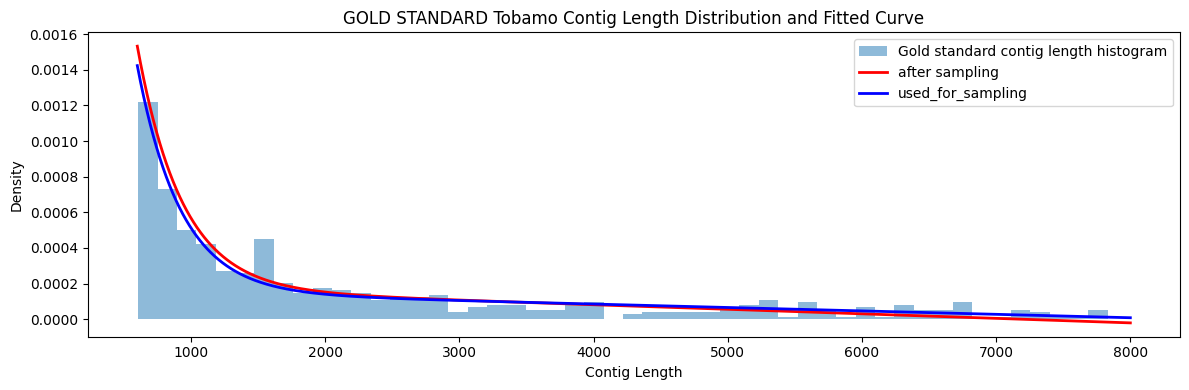

In [81]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))

ax.hist(df['contig_length'], bins=50, color='tab:blue', alpha=0.5, density=True, label='Gold standard contig length histogram')
ax.plot(xfine, sample_y_fitted, 'r-', label='after sampling', linewidth=2)
# If you have y_fitted, plot it as well
ax.plot(xfine, y_fitted, 'b-', label='used_for_sampling', linewidth=2)
ax.set_title('GOLD STANDARD Tobamo Contig Length Distribution and Fitted Curve')
ax.set_xlabel('Contig Length')
ax.set_ylabel('Density')
ax.legend()

plt.tight_layout()
plt.show()

Morf selection

In [125]:
morf_selection = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/model_selection_run1/performance_metrics.csv', index_col=0)
morf_selection2 = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/model_selection_run2/performance_metrics.csv', index_col=0)

In [128]:
morf_selection

,fold,model,accuracy,auc_roc,f1_score,recall,specificity,precision,negative_predictive_value,best_params
0,0,SVM,0.737996,0.632587,0.827269,0.901001,0.364173,0.764692,0.615982,"{'C': 50, 'kernel': 'rbf'}"
1,1,RandomForest,0.749456,0.639764,0.837042,0.953693,0.325836,0.745817,0.772334,"{'max_depth': 40, 'n_estimators': 200}"
2,2,RandomForest,0.789041,0.648903,0.868440,0.939530,0.358277,0.807352,0.674253,"{'max_depth': 40, 'n_estimators': 150}"
3,3,RandomForest,0.784079,0.648014,0.864549,0.952941,0.343087,0.791163,0.736264,"{'max_depth': None, 'n_estimators': 150}"
4,4,RandomForest,0.763568,0.631641,0.850375,0.950294,0.312988,0.769469,0.722951,"{'max_depth': 40, 'n_estimators': 150}"


In [126]:
morf_selection2

,fold,model,accuracy,auc_roc,f1_score,recall,specificity,precision,negative_predictive_value,best_params
0,0,SVM,0.737996,0.632587,0.827269,0.901001,0.364173,0.764692,0.615982,"{'C': 50, 'kernel': 'rbf'}"
1,1,RandomForest,0.745106,0.636226,0.833828,0.947831,0.324620,0.744304,0.750000,"{'max_depth': 40, 'n_estimators': 150}"
2,2,RandomForest,0.787084,0.645124,0.867382,0.939530,0.350718,0.805524,0.669553,"{'max_depth': None, 'n_estimators': 200}"
3,3,RandomForest,0.790561,0.652270,0.869180,0.962185,0.342356,0.792570,0.776119,"{'max_depth': None, 'n_estimators': 175}"
4,4,RandomForest,0.763984,0.632351,0.850599,0.950294,0.314407,0.769836,0.723856,"{'max_depth': None, 'n_estimators': 200}"


### M contig evaluation

In [26]:
comparison = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/evaluation_results/method_comparison_stats.csv', index_col=0)

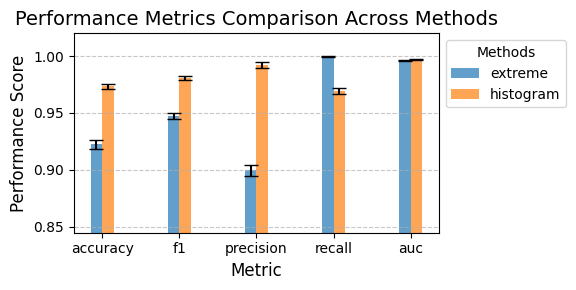

In [27]:
# Extract metrics from comparison DataFrame
metrics = ['accuracy', 'f1', 'precision', 'recall', 'auc']
methods = comparison.index

# Create figure
fig, ax = plt.subplots(figsize=(7, 3))

# Bar positioning
x = np.arange(len(metrics))
width = 0.15  # Wider bars since we may have more methods
bar_positions = [x + i * width - (len(methods) - 1) * width / 2 for i in range(len(methods))]

# Plot bars with error bars for each method
for i, method in enumerate(methods):
    means = [comparison.loc[method, f'{metric}_mean'] for metric in metrics]
    stds = [comparison.loc[method, f'{metric}_std'] for metric in metrics]
    
    ax.bar(bar_positions[i], means, width, yerr=stds, capsize=5, 
           label=method, alpha=0.7)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Performance Score', fontsize=12)

# Set y-axis limits to focus on the relevant range
y_min = max(0.5, min([comparison[f'{m}_mean'].min() - comparison[f'{m}_std'].max() for m in metrics]) - 0.05)
ax.set_ylim(y_min, 1.02)

# Add grid for easier comparison
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Title and legend
ax.set_title('Performance Metrics Comparison Across Methods', fontsize=14)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Methods")

# Add CI annotations if desired
for i, method in enumerate(methods):
    for j, metric in enumerate(metrics):
        mean = comparison.loc[method, f'{metric}_mean']
        ci_low = comparison.loc[method, f'{metric}_ci95_low']
        ci_high = comparison.loc[method, f'{metric}_ci95_high']
        
        # Optional: add text annotation for 95% CI
        # ax.text(bar_positions[i], mean + 0.02, f'[{ci_low:.3f}, {ci_high:.3f}]', 
        #        ha='center', va='bottom', fontsize=8, rotation=90)

# Adjust layout for legend
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

### Mc selection and evaluation

In [ ]:
extreme = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/evaluation_results/extreme_predictions_results.csv')
hist = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/evaluation_results/histogram_predictions_results.csv')

df = pd.concat([extreme, hist], ignore_index=True)

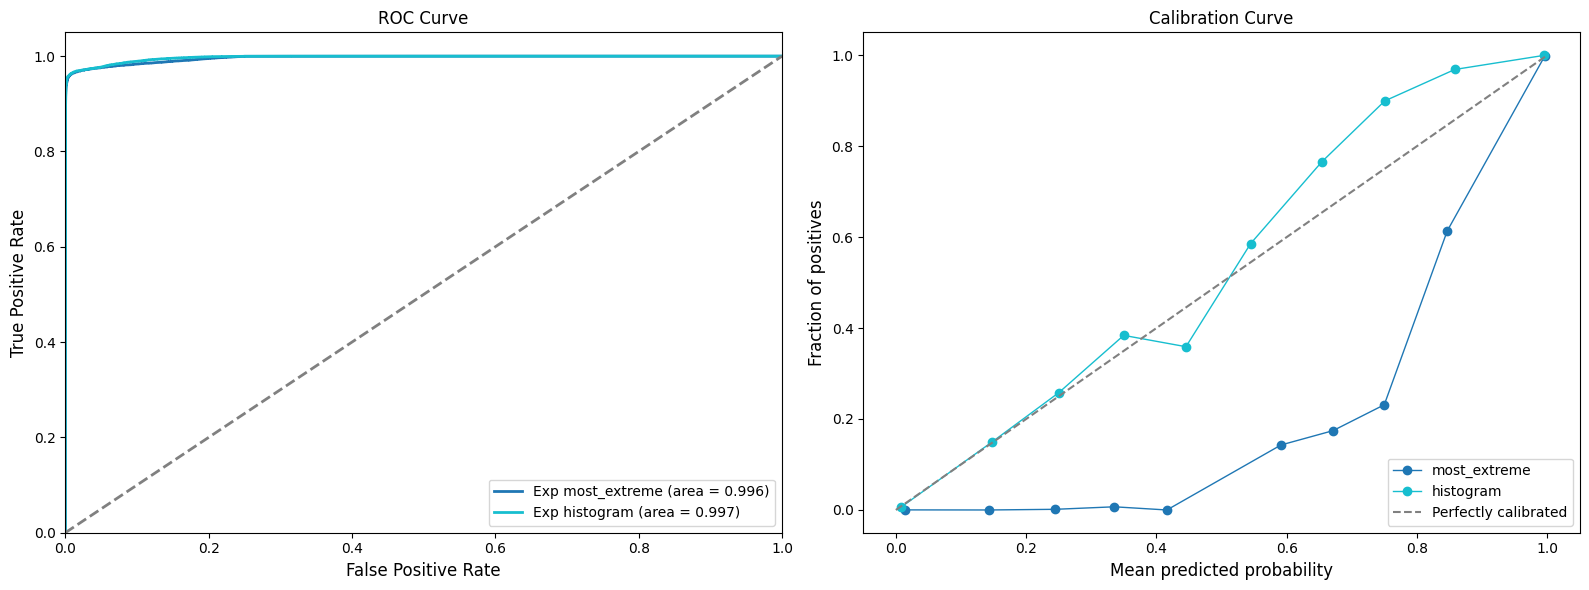

In [ ]:
methods = df['mc_name'].unique()

# Define color palette for consistent colors across methods
colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
method_colors = dict(zip(methods, colors))

# Aggregate results across all folds for each method
aggregated_results = []

for method in methods:
    method_data = df[df['mc_name'] == method]
    aggregated_results.append(method_data)

# Combine all aggregated results into a single DataFrame
combined_results = pd.concat(aggregated_results)

# Plot ROC curve, Precision-Recall curve, and Calibration curve for each method
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot ROC Curve for each method
for method in methods:
    method_data = combined_results[combined_results['mc_name'] == method]
    y_true = method_data['ground_truth']
    y_scores = method_data['prob_1']
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, lw=2, label=f'Exp {method} (area = {roc_auc:.3f})', 
                color=method_colors[method])

axes[0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=12)
axes[0].legend(loc="lower right")

# Plot Calibration Curve for each method
for method in methods:
    method_data = combined_results[combined_results['mc_name'] == method]
    y_true = method_data['ground_truth']
    y_scores = method_data['prob_1']
    prob_true, prob_pred = calibration_curve(y_true, y_scores, n_bins=10)
    axes[1].plot(prob_pred, prob_true, marker='o', lw=1, label=f'{method}', 
                color=method_colors[method])

axes[1].plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')
axes[1].set_xlabel('Mean predicted probability', fontsize=12)
axes[1].set_ylabel('Fraction of positives', fontsize=12)
axes[1].set_title('Calibration Curve', fontsize=12)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

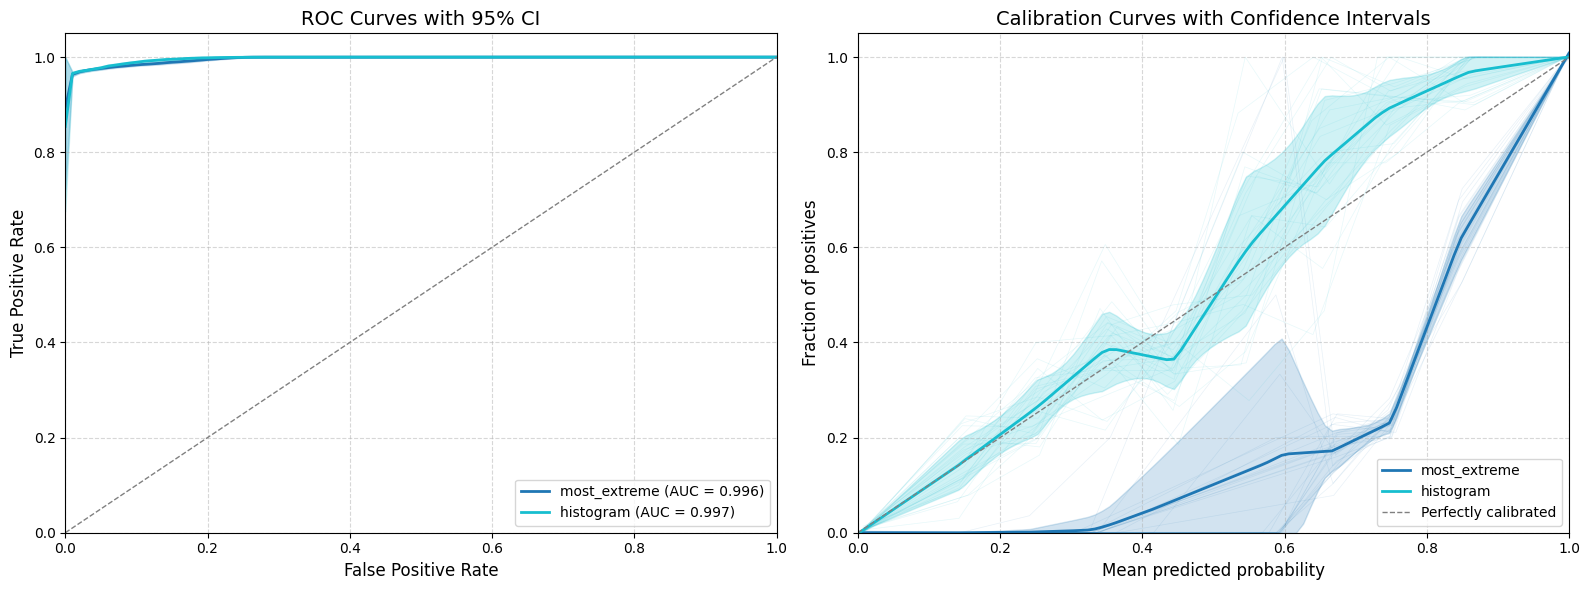

In [ ]:
# Create a figure with 2 subplots for ROC and Calibration curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define color palette for consistent colors across methods
methods = df['mc_name'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
method_colors = dict(zip(methods, colors))

# Plot ROC Curves with confidence intervals
for i, method in enumerate(methods):
    method_data = df[df['mc_name'] == method]
    
    # Store TPR values for each FPR point to calculate confidence intervals
    tpr_values = []
    interp_fpr = np.linspace(0, 1, 100)
    
    # Calculate ROC curve for each iteration
    iterations = method_data['iteration'].unique() if 'iteration' in method_data.columns else [0]
    
    for iteration in iterations:
        iter_data = method_data[method_data['iteration'] == iteration] if 'iteration' in method_data.columns else method_data
        
        if len(iter_data) > 0:
            y_true = iter_data['ground_truth']
            y_scores = iter_data['prob_1']
            
            if len(np.unique(y_true)) > 1:  # Only compute if we have both classes
                fpr, tpr, _ = roc_curve(y_true, y_scores)
                
                # Interpolate TPR values at fixed FPR points
                interp_tpr = np.interp(interp_fpr, fpr, tpr)
                tpr_values.append(interp_tpr)
    
    # Calculate mean and std of TPR values
    if tpr_values:
        tpr_array = np.array(tpr_values)
        mean_tpr = tpr_array.mean(axis=0)
        std_tpr = tpr_array.std(axis=0)
        
        # Calculate AUC of mean curve
        mean_auc = auc(interp_fpr, mean_tpr)
        
        # Plot mean ROC curve
        axes[0].plot(interp_fpr, mean_tpr, color=method_colors[method], 
                  label=f'{method} (AUC = {mean_auc:.3f})', lw=2)
        
        # Plot confidence interval (±1 std)
        axes[0].fill_between(interp_fpr, 
                          np.maximum(0, mean_tpr - std_tpr),
                          np.minimum(1, mean_tpr + std_tpr), 
                          color=method_colors[method], alpha=0.2)

# Add reference line and formatting for ROC curve
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves with 95% CI', fontsize=14)
axes[0].legend(loc="lower right")
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot Calibration Curves with confidence intervals
for i, method in enumerate(methods):
    method_data = df[df['mc_name'] == method]
    
    # Store calibration curves for confidence intervals
    prob_true_values = []
    prob_pred_values = []
    
    # Calculate calibration curve for each iteration
    iterations = method_data['iteration'].unique() if 'iteration' in method_data.columns else [0]
    
    for iteration in iterations:
        iter_data = method_data[method_data['iteration'] == iteration] if 'iteration' in method_data.columns else method_data
        
        if len(iter_data) > 0:
            y_true = iter_data['ground_truth']
            y_scores = iter_data['prob_1']
            
            # Only compute if we have enough data
            if len(y_true) > 10 and len(np.unique(y_true)) > 1:
                prob_true, prob_pred = calibration_curve(y_true, y_scores, n_bins=10)
                
                # Plot individual iteration curves with low opacity
                axes[1].plot(prob_pred, prob_true, color=method_colors[method], 
                         alpha=0.1, lw=0.5)
                
                # Store values for confidence interval
                prob_true_values.append(prob_true)
                prob_pred_values.append(prob_pred)
    
    # Calculate and plot mean calibration curve if we have data
    if prob_true_values:
        # Create interpolation grid
        x_interp = np.linspace(0, 1, 100)
        
        # Interpolate each curve to this grid
        interp_curves = []
        for prob_true, prob_pred in zip(prob_true_values, prob_pred_values):
            if len(prob_pred) > 1:
                # Use linear interpolation
                from scipy.interpolate import interp1d
                interp_func = interp1d(prob_pred, prob_true, 
                                     bounds_error=False, fill_value="extrapolate")
                interp_curves.append(interp_func(x_interp))
        
        # Calculate mean and std for the interpolated curves
        if interp_curves:
            interp_array = np.array(interp_curves)
            mean_curve = np.nanmean(interp_array, axis=0)
            std_curve = np.nanstd(interp_array, axis=0)
            
            # Plot mean curve with higher weight
            axes[1].plot(x_interp, mean_curve, color=method_colors[method], 
                      label=f'{method}', lw=2)
            
            # Plot confidence interval
            axes[1].fill_between(x_interp, 
                              np.maximum(0, mean_curve - std_curve),
                              np.minimum(1, mean_curve + std_curve), 
                              color=method_colors[method], alpha=0.2)

# Add reference line and formatting for Calibration curve
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1, label='Perfectly calibrated')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Mean predicted probability', fontsize=12)
axes[1].set_ylabel('Fraction of positives', fontsize=12)
axes[1].set_title('Calibration Curves with Confidence Intervals', fontsize=14)
axes[1].legend(loc="lower right")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Error Rate viz

In [12]:
# import histogram prediction results
df = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/evaluation_results/histogram_predictions_results.csv', index_col=0)

# add missing info
df['predicted_class'] = np.where(df['prob_1'] < 0.5, 0, 1)
df['correct_prediction'] = df['ground_truth'] == df['predicted_class']
df['contig_length'] = df["contig_name"].str.extract(r"len-(\d+)").astype(int)
df['contig_start'] = df['contig_name'].str.extract(r'_start-(\d+)').astype(int)
df['contig_end'] = df['contig_start'] + df['contig_length']

# add reference length
refs_lens = {
    re.match(r"^(.*\.\d)_", rec.id).group(1): len(rec.seq)
    for rec in SeqIO.parse('/home/tobamo/analize/model-tobamo/notebooks/MODEL/data/reference_nukleotidne.fasta', 'fasta')
}
df['accession'] = df['contig_name'].str.extract(r"^(.*\.\d)_")
df['ref_len'] = df['accession'].map(refs_lens)

# keep only tobamo
tobamo = df[df['ground_truth'] == 1]

normalize lengths

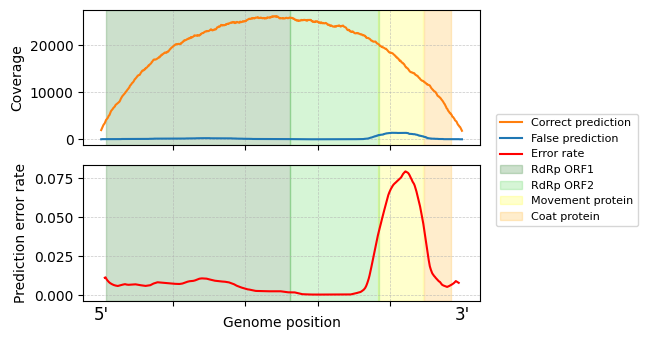

In [10]:
# Normalize contig_start and contig_end by ref_len to make lengths relative
tobamo = tobamo.copy()
tobamo['relative_start'] = tobamo['contig_start'] / tobamo['ref_len']
tobamo['relative_end'] = tobamo['contig_end'] / tobamo['ref_len']

# Define the genome length as 1 (since we're working with relative lengths)
genome_length = 1.0

# Initialize a dictionary to store coverage arrays for each correct_prediction group
coverage_by_prediction = {}

# Group the data by 'correct_prediction' and calculate coverage for each group
for prediction, group in tobamo.groupby('correct_prediction'):
    # Initialize a coverage array with zeros (use 1000 bins for relative positions)
    bins = 1000
    coverage = np.zeros(bins)
    
    # Increment the coverage array for each contig in the group
    for start, end in zip(group['relative_start'], group['relative_end']):
        start_bin = int(start * bins)
        end_bin = int(end * bins)
        coverage[start_bin:end_bin] += 1
    
    # Store the coverage array in the dictionary
    coverage_by_prediction[prediction] = coverage

# Define the genome length as 1 (since we're working with relative lengths)
genome_length = 1.0

# Initialize dictionaries to store coverage arrays for correct and incorrect predictions
bins = 1000
coverage_correct = np.zeros(bins)
coverage_incorrect = np.zeros(bins)

# Group the data by 'correct_prediction' and calculate coverage for each group
for prediction, group in tobamo.groupby('correct_prediction'):
    # Increment the coverage array for each contig in the group
    for start, end in zip(group['relative_start'], group['relative_end']):
        start_bin = int(start * bins)
        end_bin = int(end * bins)
        if prediction:  # True for correct predictions
            coverage_correct[start_bin:end_bin] += 1
        else:  # False for incorrect predictions
            coverage_incorrect[start_bin:end_bin] += 1

# Calculate the error rate (incorrect / total coverage)
total_coverage = coverage_correct + coverage_incorrect
error_rate = np.divide(coverage_incorrect, total_coverage, out=np.zeros_like(coverage_incorrect), where=total_coverage != 0)

# Create a DataFrame for plotting
coverage_df = pd.DataFrame({
    'Relative Position': np.linspace(0, genome_length, bins),
    'Error Rate': error_rate
})

# set examplery regions of interest
rdrp_orf1_start = 77/6393
rdrp_orf1_end = 3348/6393

rdrp_orf2_start = 3350/6393
rdrp_orf2_end = 4924/6393

mp_start = 4911/6393
mp_end = 5711/6393

cp_start = 5714/6393
cp_end = 6193/6393

# Create a DataFrame for plotting without smoothing
unsmoothed_coverage_df = pd.DataFrame({
    'Relative Position': np.linspace(0, genome_length, bins),
    **{f"Coverage_{prediction}": coverage for prediction, coverage in coverage_by_prediction.items()}
})

# Add a smoothed error rate using a rolling average for the second graph
coverage_df['Smoothed Error Rate'] = coverage_df['Error Rate'].rolling(window=20, center=True).mean()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 3.5), sharex=True)

# Plot the unsmoothed coverage for each correct_prediction group (first subplot)
for prediction in coverage_by_prediction.keys():
    label = "Correct prediction" if prediction else "False prediction"
    sns.lineplot(
        data=unsmoothed_coverage_df,
        x='Relative Position',
        y=f"Coverage_{prediction}",
        ax=ax1,
        label=label
    )

# Add labels and highlight regions of interest for the first subplot
ax1.set_ylabel('Coverage', fontsize=10)
ax1.axvspan(mp_start, mp_end, color='yellow', alpha=0.2, label='Movement protein')
ax1.axvspan(cp_start, cp_end, color='orange', alpha=0.2, label='Coat protein')
ax1.axvspan(rdrp_orf1_start, rdrp_orf1_end, color='darkgreen', alpha=0.2, label='RdRp ORF1')
ax1.axvspan(rdrp_orf2_start, rdrp_orf2_end, color='limegreen', alpha=0.2, label='RdRp ORF2')
ax1.grid(visible=True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Plot the smoothed error rate (second subplot)
sns.lineplot(data=coverage_df, x='Relative Position', y='Smoothed Error Rate', ax=ax2, color='red', label='Error rate')

# Add labels and highlight regions of interest for the second subplot
ax2.set_xlabel('Genome position', fontsize=10)
ax2.set_ylabel('Prediction error rate', fontsize=10)
ax2.axvspan(mp_start, mp_end, color='yellow', alpha=0.2, label='Movement protein')
ax2.axvspan(cp_start, cp_end, color='orange', alpha=0.2, label='Coat protein')
ax2.axvspan(rdrp_orf1_start, rdrp_orf1_end, color='darkgreen', alpha=0.2, label='RdRp ORF1')
ax2.axvspan(rdrp_orf2_start, rdrp_orf2_end, color='limegreen', alpha=0.2, label='RdRp ORF2')
ax2.grid(visible=True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Add custom x-axis labels (5' and 3') for both subplots
ax2.text(0.0, ax2.get_ylim()[0] - (ax2.get_ylim()[1] * 0.15), "5'", fontsize=12, ha='center', color='black')
ax2.text(1.0, ax2.get_ylim()[0] - (ax2.get_ylim()[1] * 0.15), "3'", fontsize=12, ha='center', color='black')

# Set x-axis ticks at 0.2, 0.4, 0.6, and 0.8 for gridlines
ax2.set_xticks([0.2, 0.4, 0.6, 0.8])
ax2.set_xticklabels([])

# Remove individual legends
ax1.legend_.remove()
ax2.legend_.remove()

# Create a combined legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles, labels = [], []

# Combine handles and labels, avoiding duplicates
for h, l in zip(handles1 + handles2, labels1 + labels2):
    if l not in labels:
        handles.append(h)
        labels.append(l)

# Define the desired order of legend elements
desired_order = [
    "Correct prediction",
    "False prediction",
    "Error rate",
    "RdRp ORF1",
    "RdRp ORF2",
    "Movement protein",
    "Coat protein"
]

# Reorder handles and labels based on the desired order
ordered_handles_labels = sorted(zip(handles, labels), key=lambda x: desired_order.index(x[1]))
ordered_handles, ordered_labels = zip(*ordered_handles_labels)

# Combine handles and labels, avoiding duplicates
for h, l in zip(handles1 + handles2, labels1 + labels2):
    if l not in labels:
        handles.append(h)
        labels.append(l)

fig.legend(ordered_handles, ordered_labels, loc='center left', fontsize=8, bbox_to_anchor=(0.99, 0.5))

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

#### False tobamo predictions

In [16]:
# import histogram prediction results
df = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/evaluation_results/histogram_predictions_results.csv', index_col=0)

# add missing info
df['contig_length'] = df["contig_name"].str.extract(r"len-(\d+)").astype(int)
df['predicted_class'] = np.where(df['prob_1'] < 0.5, 0, 1)
df['correct_prediction'] = df['ground_truth'] == df['predicted_class']
false = df[df['correct_prediction'] == False]

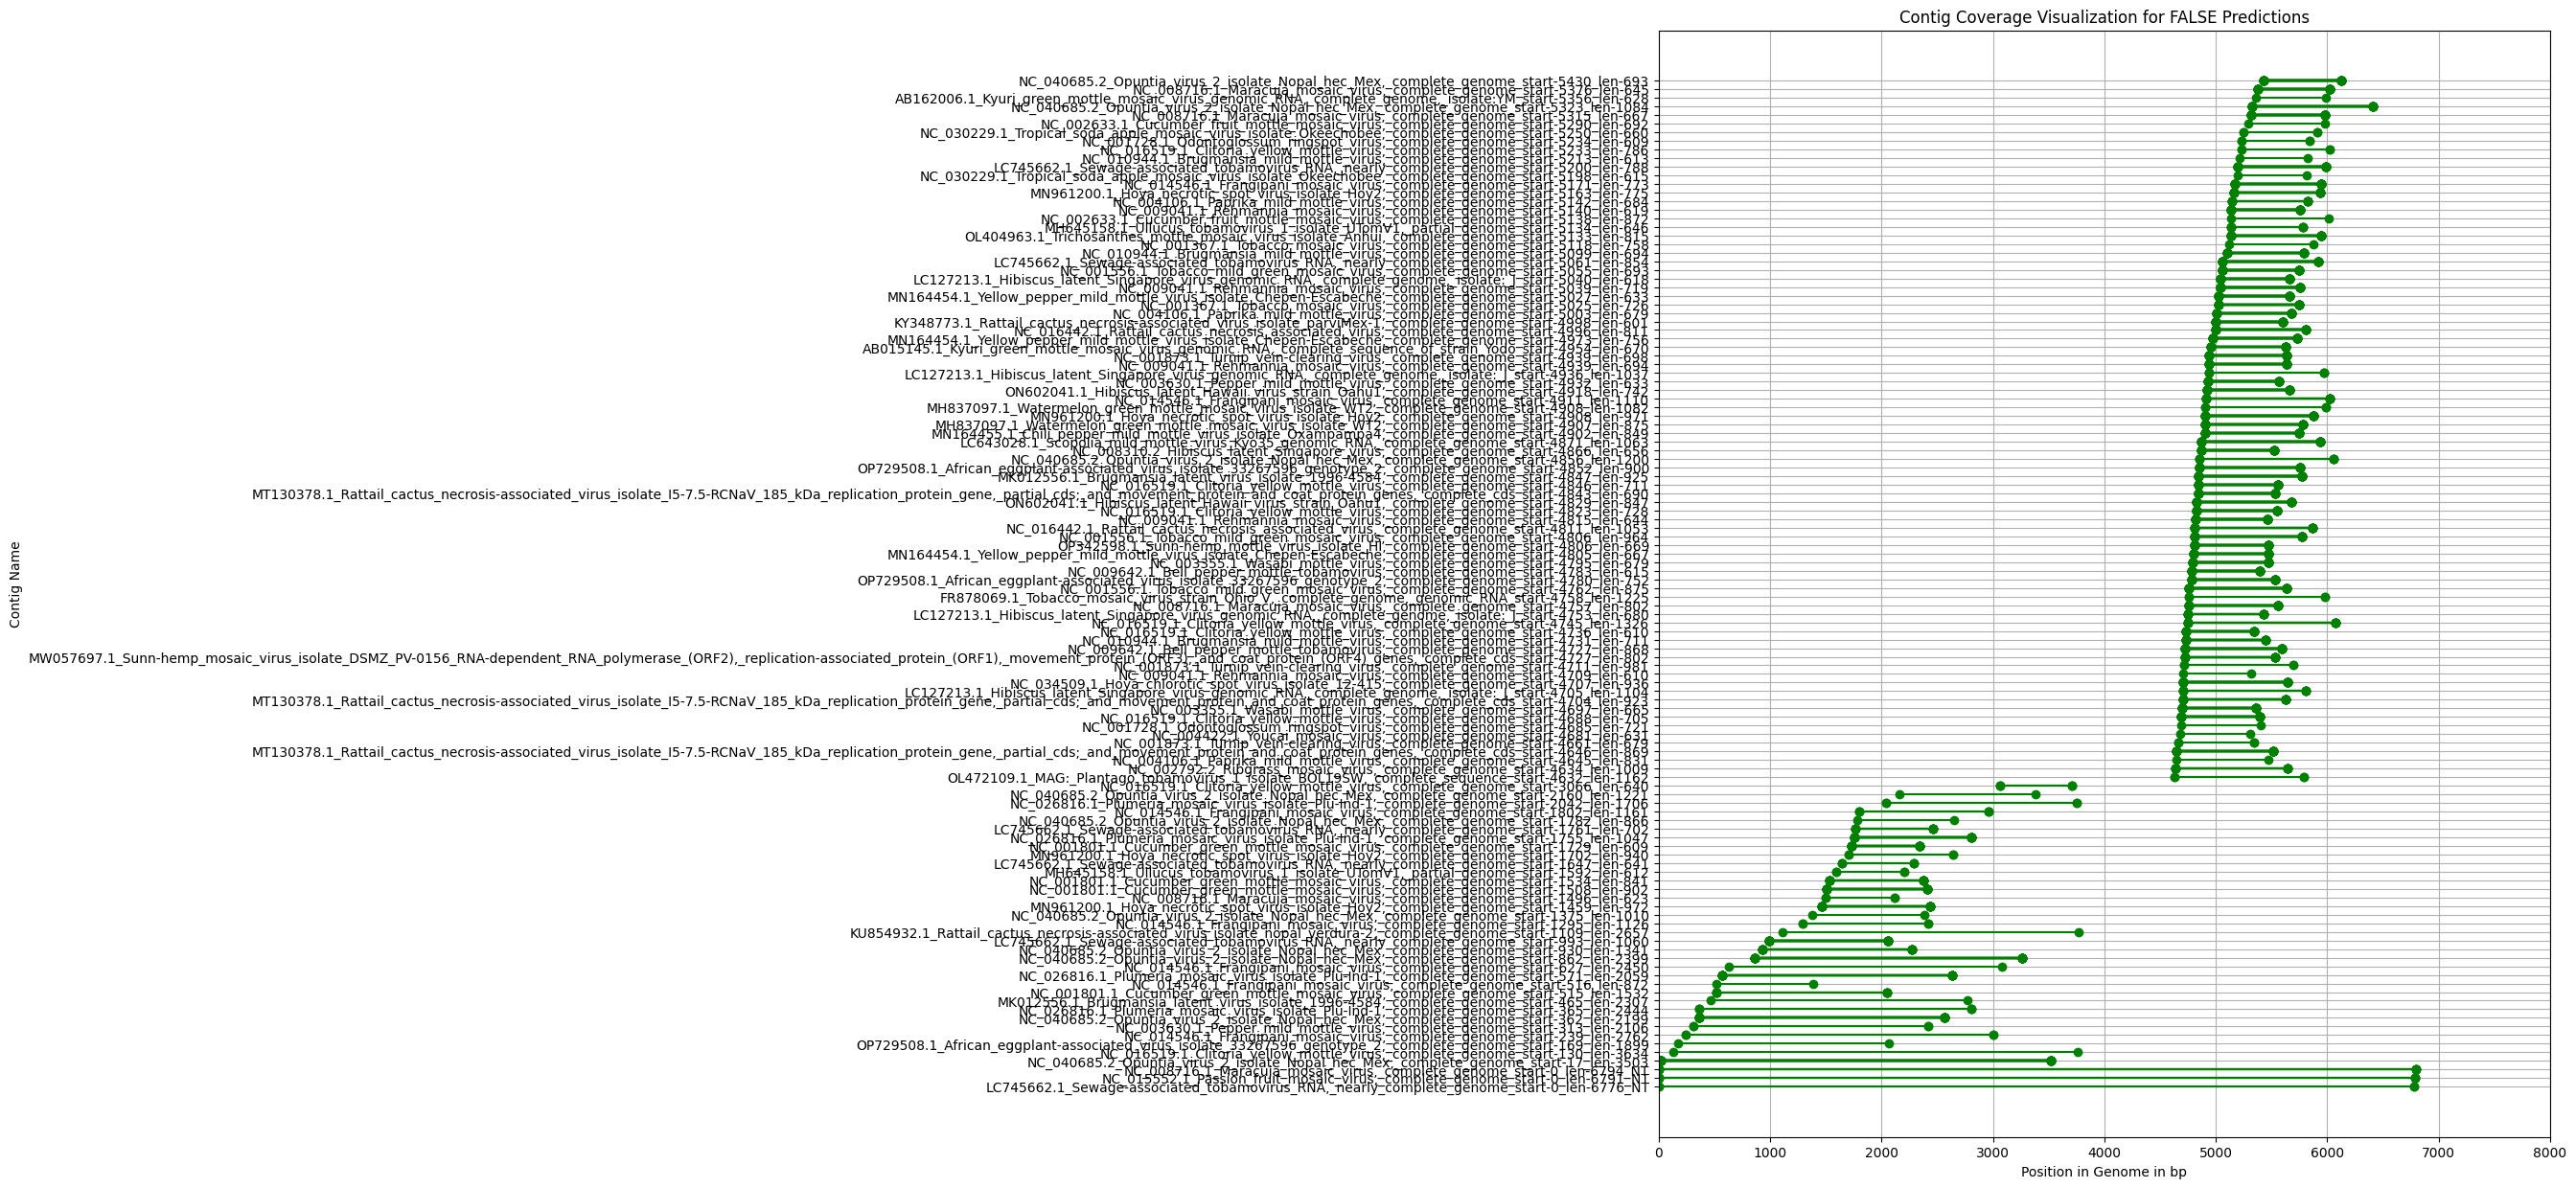

In [ ]:
import matplotlib.lines as mlines
# plot tobamo
false = false[false['ground_truth'] == 1]
false = false.copy()

false['contig_start'] = false['contig_name'].str.extract(r'_start-(\d+)').astype(int)
false['contig_length'] = false['contig_length'].astype(int)
false['contig_end'] = false['contig_start'] + false['contig_length']
false.sort_values(['contig_start', 'contig_length'], inplace=True)

# Create the plot
plt.figure(figsize=(12, 15))
colors = {True: 'green', False: 'orange'}  # Define colors for ground_truth

for _, row in false.iterrows():
    plt.plot([row['contig_start'], row['contig_end']], [row['contig_name'], row['contig_name']], 
            marker='o', color=colors[row['ground_truth']])
    
# Create custom legend handles
true_handle = mlines.Line2D([], [], color='green', marker='o', linestyle='-', markersize=5, label='tobamo')

plt.xlim(0, 8000)
plt.xlabel('Position in Genome in bp')
plt.ylabel('Contig Name')
plt.title(f'Contig Coverage Visualization for FALSE Predictions')
plt.grid(True)
plt.show()

### Feature importance

In [64]:
fi = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/final_model/top_20_features.csv')

/tmp/ipykernel_3152196/3881390312.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi, palette='viridis')


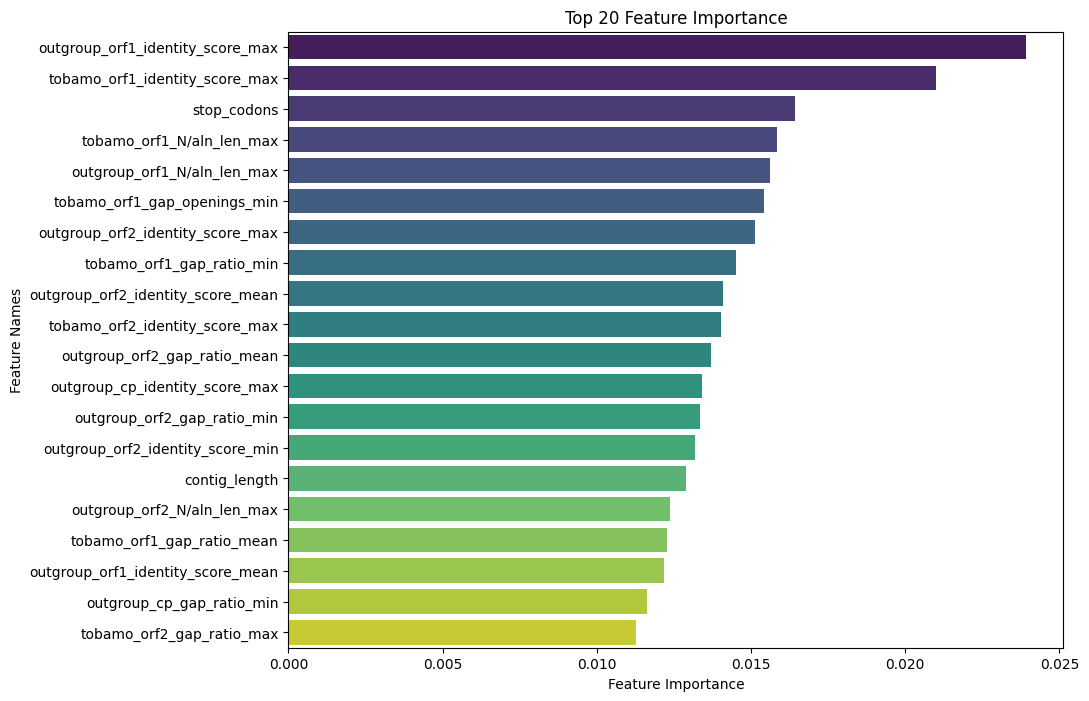

In [67]:
# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=fi, palette='viridis')
plt.title('Top 20 Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.show()

### Explained variance by number of features

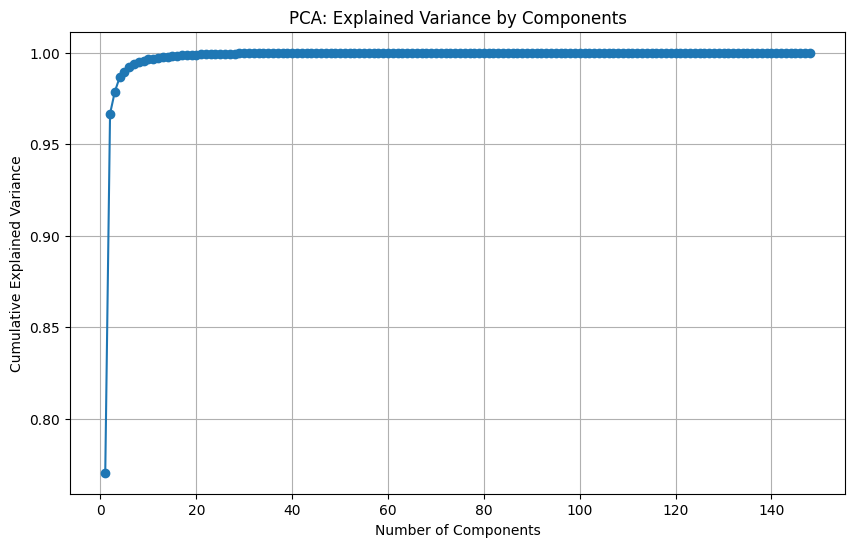

In [68]:
# 4. Dimensionality reduction with PCA
from sklearn.decomposition import PCA

# Load the training input data
training_data = pd.read_csv('../results/training/training_input.csv', index_col=0)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(training_data.select_dtypes(include=[float, int]))

# Plot variance explained by components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance by Components')
plt.grid(True)
plt.show()

### SNAKEMAKE RESULTS

In [83]:
gt = pd.read_excel('/home/tobamo/analize/project-tobamo/analysis/data/domain_sci_input/ground_truth_20250630.xlsx')
gt.columns = gt.columns.str.strip()
pr = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/predictions/contig_predictions.csv')
merge = pd.merge(gt, pr, on='contig_name', how='inner')

confusion matrix

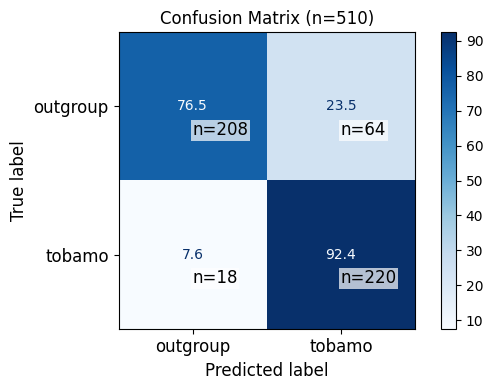

In [85]:
# Generate the confusion matrix
cm = confusion_matrix(merge['ground_truth'], merge['predicted_class'])

# Normalize the confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Display the confusion matrix with percentages - use custom labels
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_percentage,
    display_labels=['outgroup', 'tobamo']  # Custom labels instead of 0,1
)
disp.plot(cmap=plt.cm.Blues, values_format=".1f", ax=ax)

# Set fontsize for tick labels and axis labels
ax.tick_params(labelsize=12)
ax.set_xlabel('Predicted label', fontsize=12)
ax.set_ylabel('True label', fontsize=12)

# Add text annotations for the actual counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Position the raw count in the top-left corner of each cell
        ax.text(j, i+0.1, f"n={cm[i, j]}", 
                va='top', ha='left',
                fontsize=12, 
                color='black', 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Set title and adjust layout
plt.title(f"Confusion Matrix (n={len(merge)})")
plt.tight_layout()
plt.show()

AUC ROC

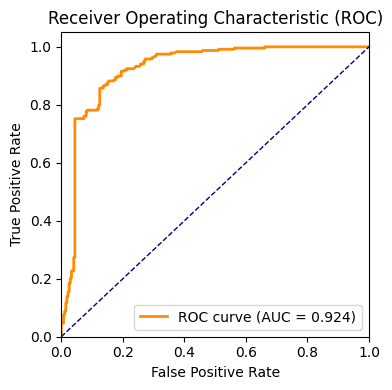

In [86]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(df['ground_truth'], df['prob_1'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

BOXPLOT, STRIPPLOT and VIOLINPLOT

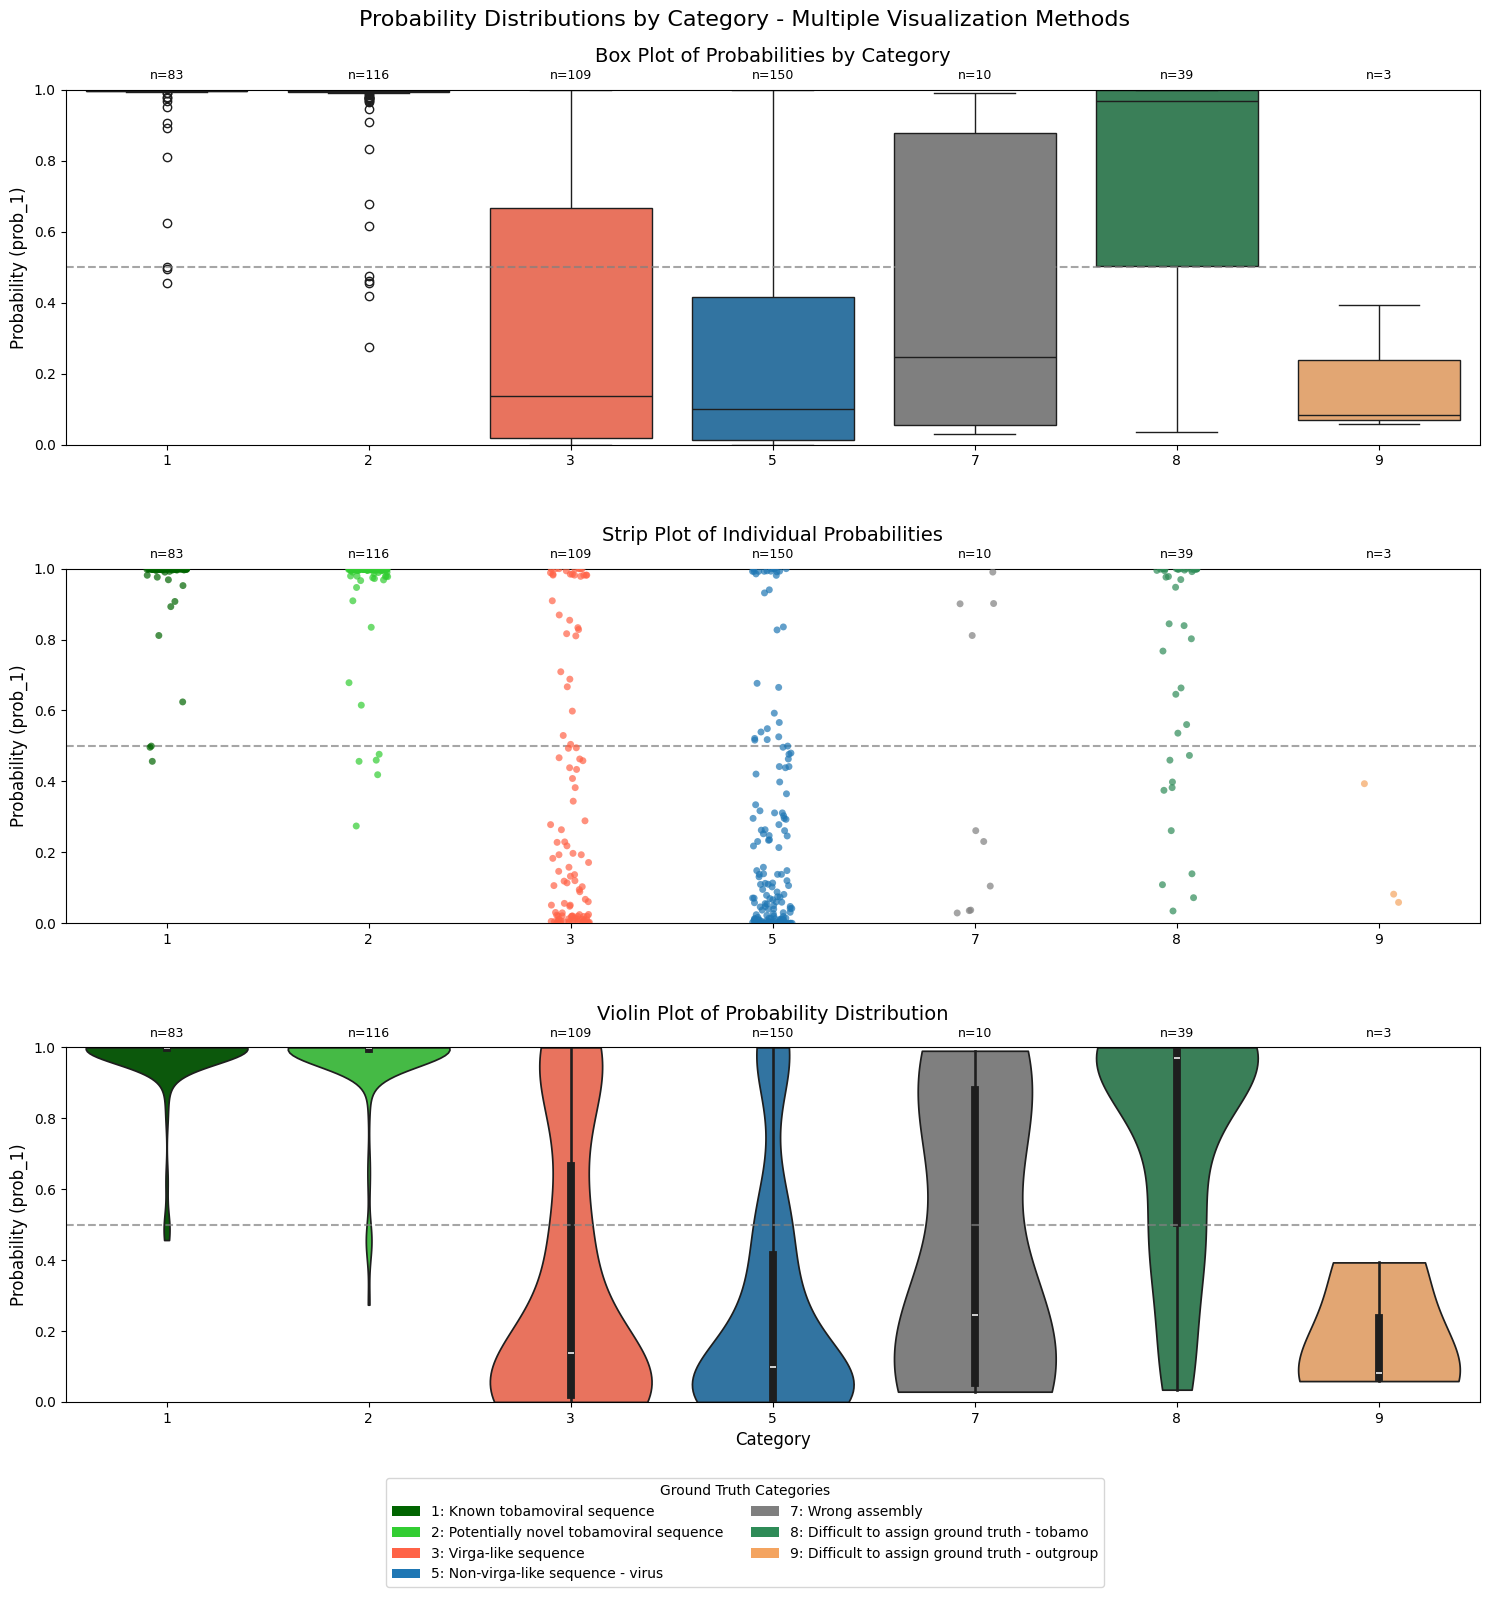

In [115]:
# Create a figure with three subplots (box, strip, and violin)
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

df_filtered = merge.copy()
df_filtered['category'] = df_filtered['category'].astype(str)
df_filtered['prob_1'] = df_filtered['prob_1'].astype(float)
sorted_labels = sorted(df_filtered['category'].dropna().unique())

# Define the category palette
category_palette = {
    '1': "#006400",   # dark green
    '2': "#32CD32",   # lime green
    '8': "#2E8B57",   # sea green
    '3': "#FF6347",   # tomato
    '4': "#FFA500",   # orange
    '9': "#F4A460",   # sandy brown
    '5': "#1f77b4",   # blue
    '6': "#6baed6",   # light blue
    '7': "#7f7f7f",   # grey
}

# Define category descriptions
category_map = {
    '1': "Known tobamoviral sequence",
    '2': "Potentially novel tobamoviral sequence",
    '3': "Virga-like sequence",
    '4': "Known virga-outgroup",
    '5': "Non-virga-like sequence - virus",
    '6': "Non-virga-like sequence - other",
    '7': "Wrong assembly",
    '8': "Difficult to assign ground truth - tobamo",
    '9': "Difficult to assign ground truth - outgroup"
}

# 1. Box plot with proper hue parameter
sns.boxplot(data=df_filtered, x='category', y='prob_1', order=sorted_labels, 
           hue='category', palette=category_palette, legend=False, ax=axes[0])
axes[0].set_title('Box Plot of Probabilities by Category', fontsize=14, pad=20)
axes[0].set_ylabel('Probability (prob_1)', fontsize=12)
axes[0].set_ylim(0, 1)  # Enforce proper probability range
axes[0].set_xlabel('')  # Remove x-axis label as it will be shown only on the bottom plot

# Add reference line at 0.5 (classification threshold)
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)

# 2. Strip plot with proper hue parameter
sns.stripplot(data=df_filtered, x='category', y='prob_1', order=sorted_labels, 
              jitter=True, alpha=0.7, hue='category', palette=category_palette,
              legend=False, ax=axes[1])
axes[1].set_title('Strip Plot of Individual Probabilities', fontsize=14, pad=20)
axes[1].set_ylabel('Probability (prob_1)', fontsize=12)
axes[1].set_ylim(0, 1)  # Enforce proper probability range
axes[1].set_xlabel('')  # Remove x-axis label as it will be shown only on the bottom plot
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)  # Add threshold line

# 3. Violin plot with proper hue parameter
sns.violinplot(data=df_filtered, x='category', y='prob_1', order=sorted_labels, 
              cut=0, hue='category', palette=category_palette, legend=False, ax=axes[2])
axes[2].set_title('Violin Plot of Probability Distribution', fontsize=14, pad=20)
axes[2].set_xlabel('Category', fontsize=12)
axes[2].set_ylabel('Probability (prob_1)', fontsize=12)
axes[2].set_ylim(0, 1)  # Enforce proper probability range
axes[2].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)  # Add threshold line

# Set x-axis ticks without rotation for all subplots
for ax in axes:
    # Don't rotate the labels
    ax.tick_params(axis='x', rotation=0)
    
    # Make x-tick labels visible on all subplots (override sharex behavior)
    ax.xaxis.set_tick_params(labelbottom=True)
    
    # Add padding between tick labels
    plt.setp(ax.get_xticklabels(), ha='center')
    
    # Add counts above each category
    for i, category in enumerate(sorted_labels):
        count = len(df_filtered[df_filtered['category'] == category])
        ax.text(i, 1.03, f'n={count}', ha='center', fontsize=9)

# Create legend patches with category colors and descriptions
legend_handles = []
for cat in sorted(category_palette.keys()):
    if cat in df_filtered['category'].unique():  # Only include categories present in the data
        patch = plt.Rectangle((0,0), 1, 1, fc=category_palette[cat])
        legend_handles.append((patch, f"{cat}: {category_map[cat]}"))

patches, labels = zip(*legend_handles)

# Add a legend for the figure with the category descriptions
fig.legend(
    patches, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    title="Ground Truth Categories",
    fontsize=10,
    ncol=2
)

# Add a main title for the entire figure
fig.suptitle('Probability Distributions by Category - Multiple Visualization Methods', 
             fontsize=16, y=0.99)

# Adjust layout with increased spacing between subplots to accommodate labels
plt.tight_layout()
plt.subplots_adjust(bottom=0.12, top=0.94, hspace=0.35)  # Increased hspace for labels
plt.show()

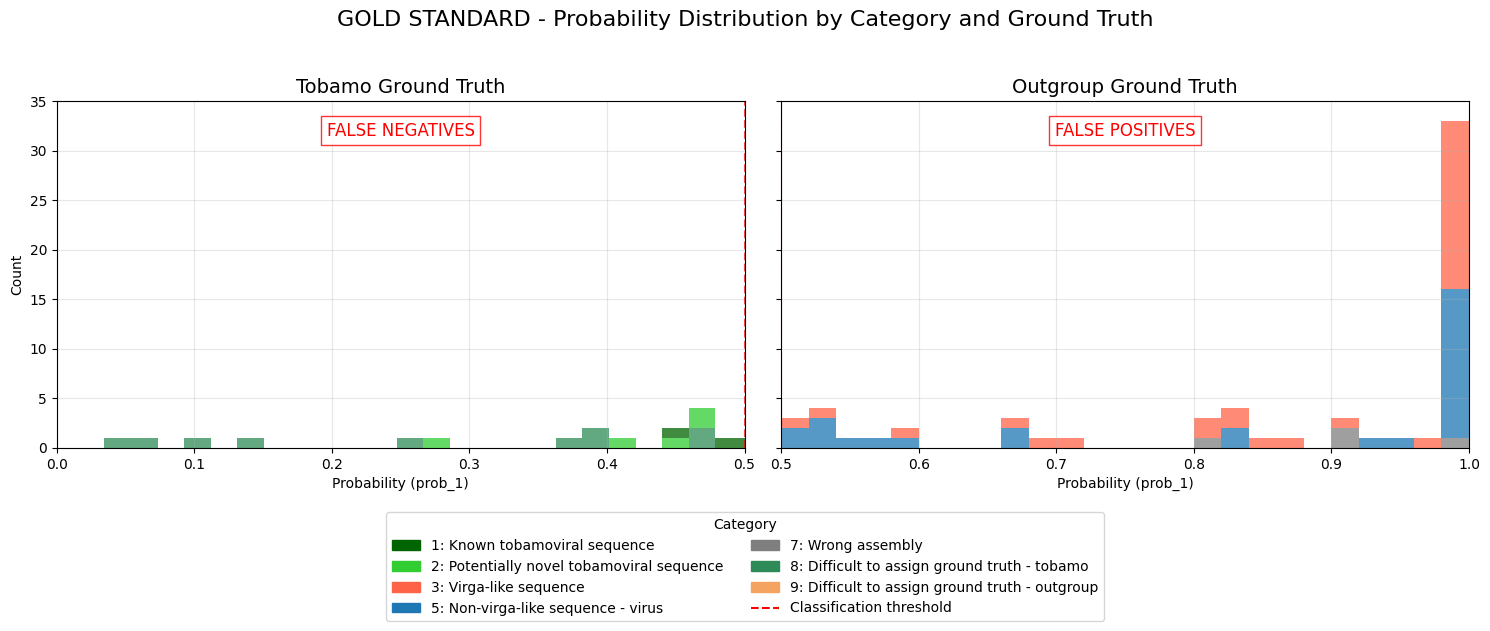

In [124]:
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt

# Map ground_truth values to labels
col_labels = {0.0: 'outgroup', 1.0: 'tobamo'}
merge['ground_truth_label'] = merge['ground_truth'].map(col_labels)

category_map = {
    1: "Known tobamoviral sequence",
    2: "Potentially novel tobamoviral sequence",
    3: "Virga-like sequence",
    4: "Known virga-outgroup",
    5: "Non-virga-like sequence - virus",
    6: "Non-virga-like sequence - other",
    7: "Wrong assembly",
    8: "Difficult to assign ground truth - tobamo",
    9: "Difficult to assign ground truth - outgroup"
}

category_palette = {
    1: "#006400",   # dark green
    2: "#32CD32",   # lime green
    8: "#2E8B57",   # sea green
    3: "#FF6347",   # tomato
    4: "#FFA500",   # orange
    9: "#F4A460",   # sandy brown
    5: "#1f77b4",   # blue
    6: "#6baed6",   # light blue
    7: "#7f7f7f",   # grey
}

# Create a figure with two subplots side by side (one for each ground truth label)
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Convert category to numeric type if it's not already
if merge['category'].dtype != 'int64':
    merge['category'] = merge['category'].astype(int)

# Prepare data for tobamo and outgroup
tobamo_data = merge[merge['ground_truth_label'] == 'tobamo']
outgroup_data = merge[merge['ground_truth_label'] == 'outgroup']

# Plot histograms for tobamo (ground truth = 1)
sns.histplot(
    data=tobamo_data,
    x="prob_1",
    hue="category",
    bins=50,
    multiple="stack",
    palette=category_palette,
    edgecolor=None,
    ax=axes[0]
)
axes[0].set_title('Tobamo Ground Truth', fontsize=14)
axes[0].set_xlabel("Probability (prob_1)")
axes[0].set_ylabel("Count")
axes[0].set_xlim(0, 0.5)
axes[0].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
axes[0].grid(alpha=0.3)
axes[0].set_ylim(0, 35)

# Plot histograms for outgroup (ground truth = 0)
sns.histplot(
    data=outgroup_data,
    x="prob_1",
    hue="category",
    bins=50,
    multiple="stack",
    palette=category_palette,
    edgecolor=None,
    ax=axes[1]
)
axes[1].set_title('Outgroup Ground Truth', fontsize=14)
axes[1].set_xlabel("Probability (prob_1)")
axes[1].set_xlim(0.5, 1)  # Focus on false positives
axes[1].set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
axes[1].grid(alpha=0.3)
axes[1].set_ylim(0, 35)

# Add classification threshold line
axes[0].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Classification threshold')
axes[1].axvline(x=0.5, color='red', linestyle='--', alpha=0.7)

# Remove legends from the histplots
axes[0].get_legend().remove()
axes[1].get_legend().remove()

# Add annotation for false predictions
axes[0].text(0.25, axes[0].get_ylim()[1]*0.9, "FALSE NEGATIVES", 
            ha='center', fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

axes[1].text(0.75, axes[1].get_ylim()[1]*0.9, "FALSE POSITIVES", 
            ha='center', fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

# Custom legend for categories with descriptive names
handles = [
    mpatches.Patch(color=category_palette[cat], label=f'{cat}: {category_map[cat]}')
    for cat in sorted(category_palette.keys())
    if cat in merge['category'].unique()  # Only include categories present in the data
]

# Add threshold line to legend
handles.append(plt.Line2D([0], [0], color='red', linestyle='--', label='Classification threshold'))

# Add a common legend for both plots
fig.legend(
    handles=handles,
    title="Category",
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    frameon=True,
    ncol=2,
    fontsize=10
)

plt.suptitle("GOLD STANDARD - Probability Distribution by Category and Ground Truth", y=1.03, fontsize=16)

# Adjust layout with space for the legend at the bottom
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)

plt.show()